In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### FILL MACROS

In [7]:
macro = pd.read_excel('/kaggle/input/dtsetnpl/dtset.xlsx', sheet_name='macros')

macro.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,time,IR,GDP,IIP,INF,CPI,UN,M2
0,2012q1,0.138700,0.0464,0.0650,NaN,0.1415,0.0222,NaN
1,2012q2,0.113667,0.0480,0.0802,NaN,0.0690,0.0218,NaN
2,2012q3,0.092067,0.0505,0.0965,NaN,0.0648,0.0229,NaN
3,2012q4,0.093667,0.0544,0.0593,NaN,0.0681,0.0212,NaN
4,2013q1,0.090000,0.0476,0.0516,NaN,0.0664,0.0227,NaN


In [8]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    51 non-null     object 
 1   IR      51 non-null     float64
 2   GDP     51 non-null     float64
 3   IIP     51 non-null     float64
 4   INF     38 non-null     float64
 5   CPI     51 non-null     float64
 6   UN      51 non-null     float64
 7   M2      46 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.3+ KB


In [9]:
zero_counts = (macro == 0).sum()
nan_counts = macro.isna().sum()

checking = pd.DataFrame({
    "Cột": macro.columns,
    "Số giá trị NaN": nan_counts.values,
    "Số giá trị 0": zero_counts.values
})

checking

,Cột,Số giá trị NaN,Số giá trị 0
0,time,0,0
1,IR,0,0
2,GDP,0,0
3,IIP,0,0
4,INF,13,0
5,CPI,0,1
6,UN,0,0
7,M2,5,0


In [10]:
macro['CPI'] = macro['CPI'].replace(0, macro['CPI'].mean())

macro['M2'] = macro['M2'].fillna(macro['M2'].mean())

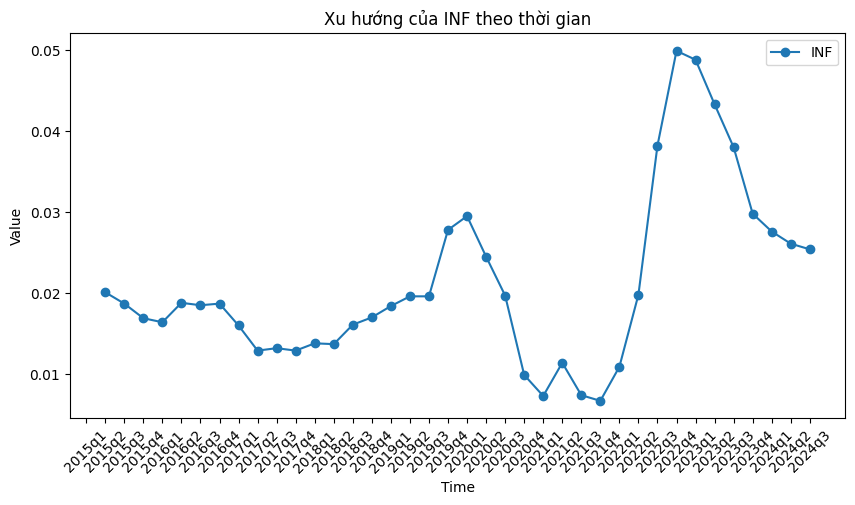

In [11]:
# Kiểm tra xu hướng của INF 
plt.figure(figsize=(10, 5))

plt.plot(macro['time'], macro['INF'], marker='o', linestyle='-', label='INF')
# plt.plot(macro['time'], macro['M2'], marker='s', linestyle='--', label='M2')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Xu hướng của INF theo thời gian')
plt.legend()
plt.xticks(rotation=45)
plt.show()

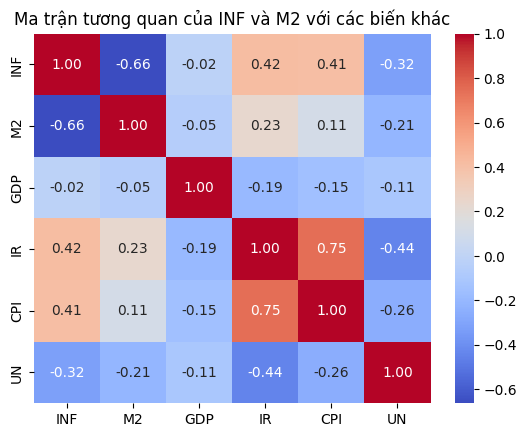

In [12]:
corr_matrix = macro[['INF', 'M2', 'GDP', 'IR', 'CPI', 'UN']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan của INF và M2 với các biến khác')
plt.show()

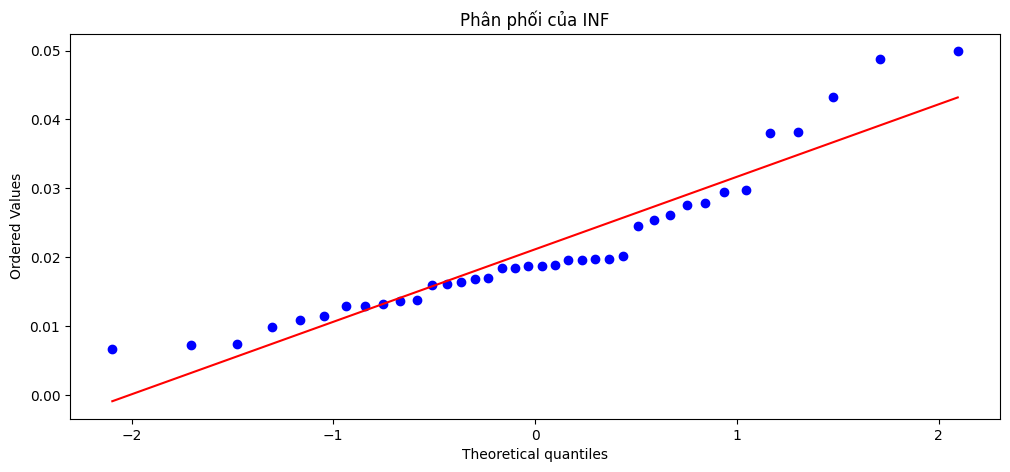

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

stats.probplot(macro['INF'].dropna(), dist="norm", plot=ax)
ax.set_title('Phân phối của INF')

plt.show()

In [14]:
macro = macro.drop(columns=['time'], errors='ignore')

macro.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,IR,GDP,IIP,INF,CPI,UN,M2
0,0.138700,0.0464,0.0650,NaN,0.1415,0.0222,0.142546
1,0.113667,0.0480,0.0802,NaN,0.0690,0.0218,0.142546
2,0.092067,0.0505,0.0965,NaN,0.0648,0.0229,0.142546
3,0.093667,0.0544,0.0593,NaN,0.0681,0.0212,0.142546
4,0.090000,0.0476,0.0516,NaN,0.0664,0.0227,0.142546


In [15]:
# INF có tương quan với IR (0.42) và CPI (0.41), có thể dùng mô hình để dự báo giá trị INF bị thiếu.

from sklearn.linear_model import LinearRegression

# Lọc các hàng có dữ liệu đầy đủ
macro_full = macro.dropna(subset=['INF', 'M2', 'IR', 'CPI'])

# Xác định biến độc lập và biến phụ thuộc
X = macro_full[['M2', 'IR', 'CPI']]
y = macro_full['INF']

# Huấn luyện mô hình hồi quy
model = LinearRegression()
model.fit(X, y)

# Dự đoán INF cho các hàng bị thiếu
macro_missing = macro[macro['INF'].isna()].copy()

# Xử lý NaN trong biến đầu vào (M2, IR, CPI)
macro_missing[['M2', 'IR', 'CPI']] = macro_missing[['M2', 'IR', 'CPI']].fillna(macro.median())

# Dự đoán và điền INF
macro.loc[macro['INF'].isna(), 'INF'] = model.predict(macro_missing[['M2', 'IR', 'CPI']])

In [16]:
macro.head()

,IR,GDP,IIP,INF,CPI,UN,M2
0,0.138700,0.0464,0.0650,0.077932,0.1415,0.0222,0.142546
1,0.113667,0.0480,0.0802,0.051799,0.0690,0.0218,0.142546
2,0.092067,0.0505,0.0965,0.043300,0.0648,0.0229,0.142546
3,0.093667,0.0544,0.0593,0.044649,0.0681,0.0212,0.142546
4,0.090000,0.0476,0.0516,0.042969,0.0664,0.0227,0.142546


In [17]:
macro.to_csv("/kaggle/working/filled_macros.csv", index=False)

### FILL MICROS

In [18]:
micro = pd.read_excel('/kaggle/input/dtsetnpl/dtset.xlsx', sheet_name='data')

micro.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,bank,quarterly,year,time,NPL,IR,GDP,IIP,INF,CPI,UN,M2,PCR,LTA,ROA,ROE,LDR
0,ABB,1,2012,2012q1,0.0325,0.138700,0.0464,0.0650,NaN,0.1415,0.0222,NaN,0.0160,0.0000,0.0074,0.0655,0.0000
1,ABB,2,2012,2012q2,0.0325,0.113667,0.0480,0.0802,NaN,0.0690,0.0218,NaN,0.0153,0.3997,0.0000,0.0000,0.5473
2,ABB,3,2012,2012q3,0.0325,0.092067,0.0505,0.0965,NaN,0.0648,0.0229,NaN,0.0160,0.0000,0.0074,0.0655,0.0000
3,ABB,4,2012,2012q4,0.0290,0.093667,0.0544,0.0593,NaN,0.0681,0.0212,NaN,0.0221,0.3986,0.0091,0.0830,0.5047
4,ABB,1,2013,2013q1,0.0325,0.090000,0.0476,0.0516,NaN,0.0664,0.0227,NaN,0.0221,0.4076,0.0088,0.0830,1.6140


In [19]:
zero_counts = (micro == 0).sum()
nan_counts = micro.isna().sum()

checking = pd.DataFrame({
    "Cột": micro.columns,
    "Số giá trị NaN": nan_counts.values,
    "Số giá trị 0": zero_counts.values
})

checking

,Cột,Số giá trị NaN,Số giá trị 0
0,bank,0,0
1,quarterly,0,0
2,year,0,0
3,time,0,0
4,NPL,0,0
5,IR,0,0
6,GDP,0,0
7,IIP,0,0
8,INF,299,0
9,CPI,0,23


In [20]:
cols_to_check = ['PCR', 'LTA', 'ROA', 'ROE', 'LDR']

# Duyệt qua từng biến và tạo bảng riêng
for col in cols_to_check:
    # Lọc các ngân hàng có NaN hoặc 0 trong biến đó
    filtered_data = micro[micro[col].isna() | (micro[col] == 0)]
    
    # Nhóm theo ngân hàng và đếm số lượng NaN, số lượng 0
    summary_table = filtered_data.groupby('bank')[col].apply(lambda x: pd.Series({
        'Số lượng NaN': x.isna().sum(),
        'Số lượng 0': (x == 0).sum()
    })).reset_index()
    
    # Hiển thị bảng
    print(f"Biến {col}:\n")
    print(summary_table)
    print("\n" + "="*50 + "\n")

Biến PCR:

  bank       level_1  PCR
0  BID  Số lượng NaN    2
1  BID    Số lượng 0    0


Biến LTA:

   bank       level_1  LTA
0   ABB  Số lượng NaN    0
1   ABB    Số lượng 0    2
2   BID  Số lượng NaN    2
3   BID    Số lượng 0    0
4   KLB  Số lượng NaN    0
5   KLB    Số lượng 0    1
6   SGB  Số lượng NaN    0
7   SGB    Số lượng 0    1
8   SSB  Số lượng NaN    0
9   SSB    Số lượng 0    3
10  TCB  Số lượng NaN    0
11  TCB    Số lượng 0    1
12  TPB  Số lượng NaN    0
13  TPB    Số lượng 0    3
14  VBB  Số lượng NaN    0
15  VBB    Số lượng 0    4
16  VIB  Số lượng NaN    0
17  VIB    Số lượng 0    1


Biến ROA:

   bank       level_1  ROA
0   ABB  Số lượng NaN    0
1   ABB    Số lượng 0    3
2   BID  Số lượng NaN    2
3   BID    Số lượng 0    0
4   KLB  Số lượng NaN    0
5   KLB    Số lượng 0    2
6   MSB  Số lượng NaN    0
7   MSB    Số lượng 0    2
8   NAB  Số lượng NaN    0
9   NAB    Số lượng 0    3
10  OCB  Số lượng NaN    0
11  OCB    Số lượng 0    6
12  PGB  Số lượng NaN

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



📌 Kiểm tra biến: PCR - Các ngân hàng cần kiểm tra: ['BID']



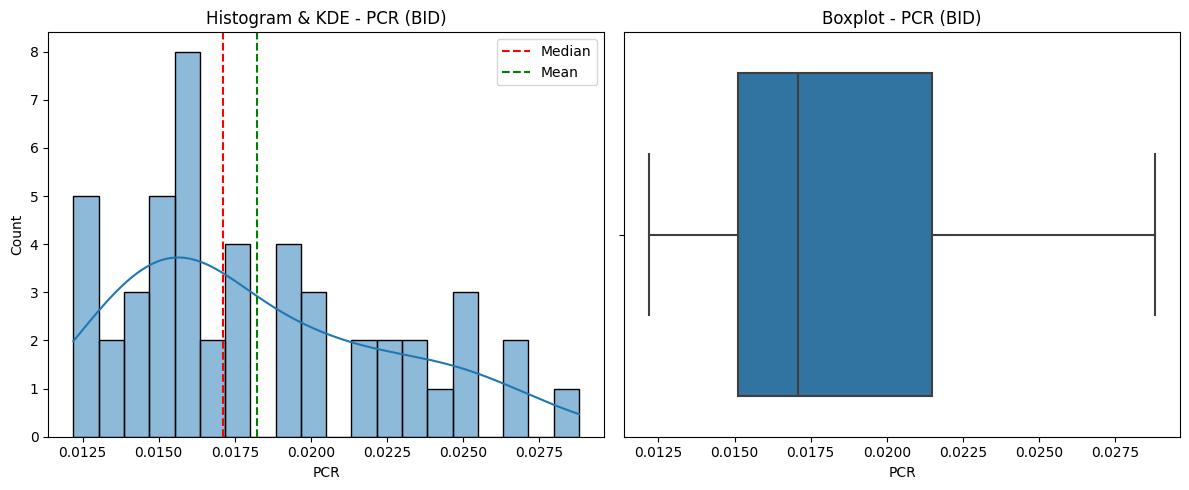


📌 Kiểm tra biến: LTA - Các ngân hàng cần kiểm tra: ['ABB' 'BID' 'KLB' 'SGB' 'SSB' 'TCB' 'TPB' 'VBB' 'VIB']



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


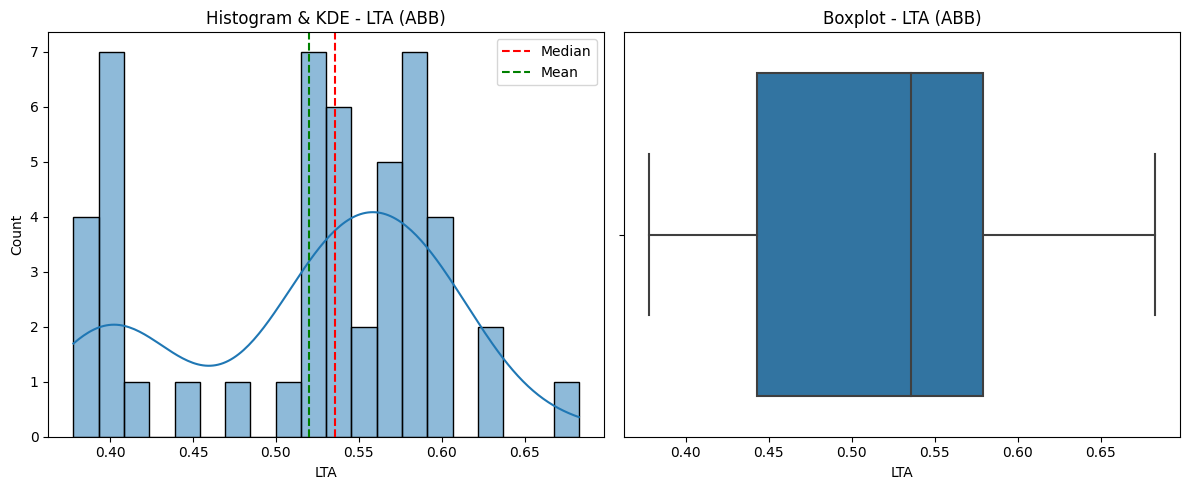

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


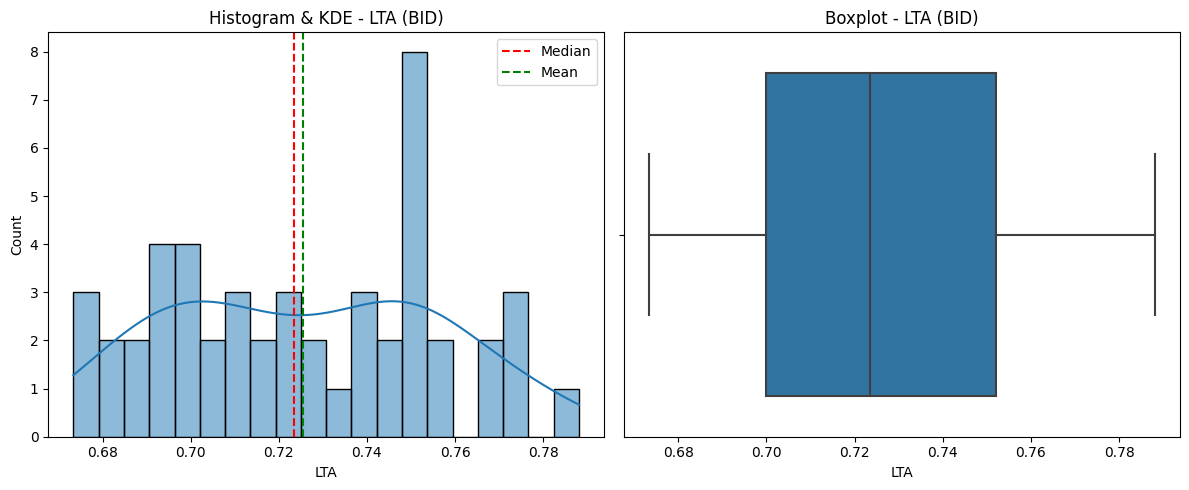

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


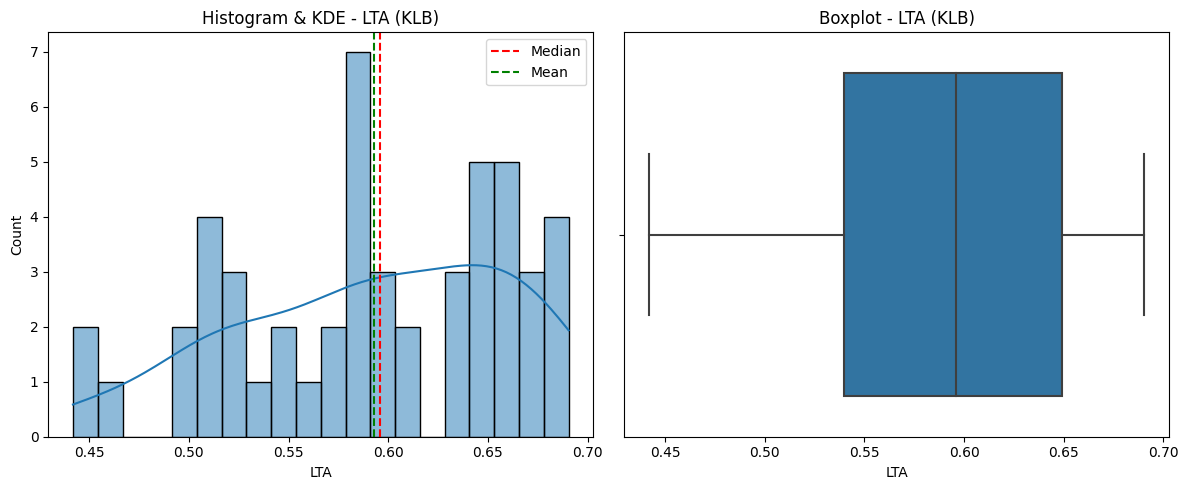

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


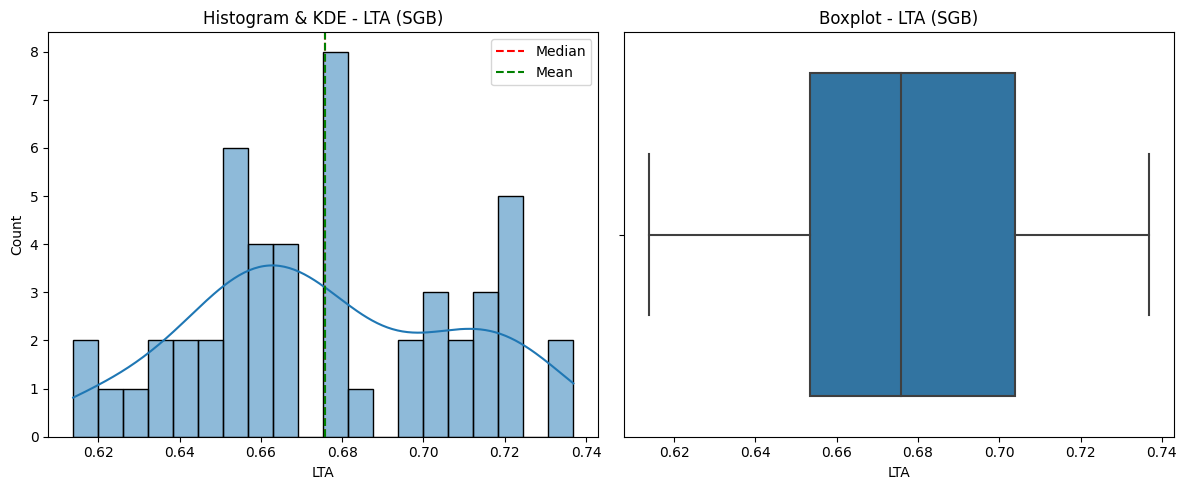

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


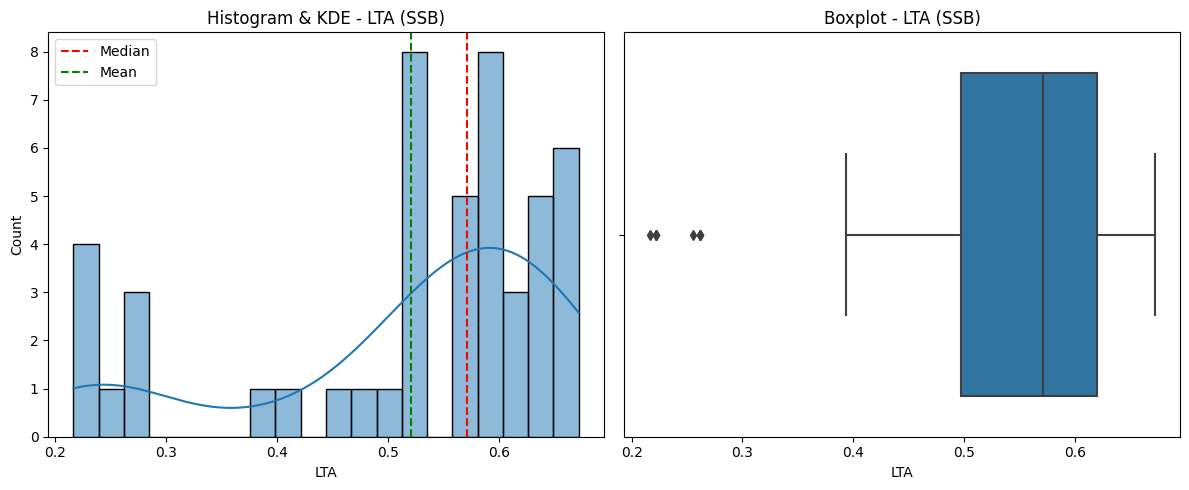

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


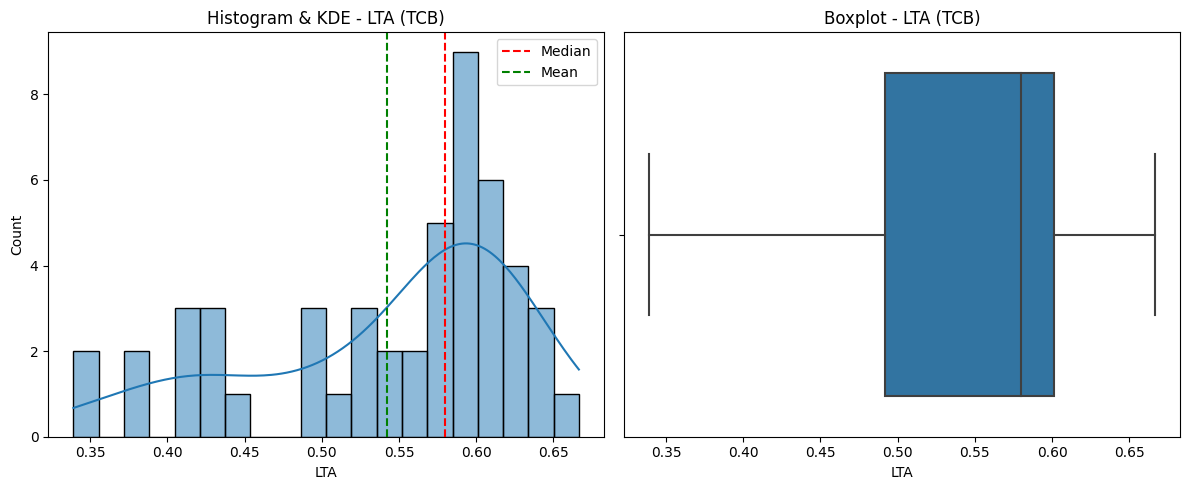

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


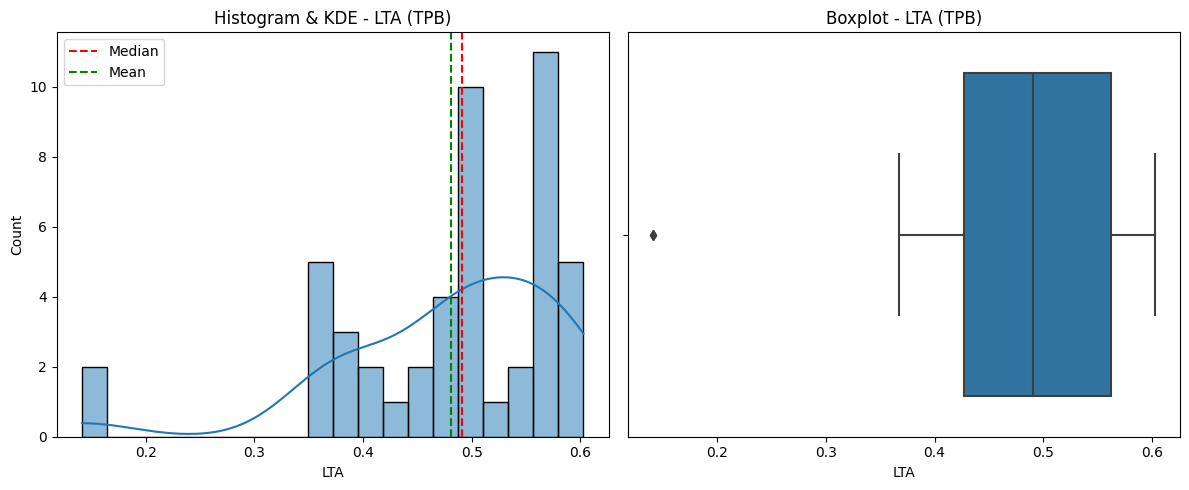

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


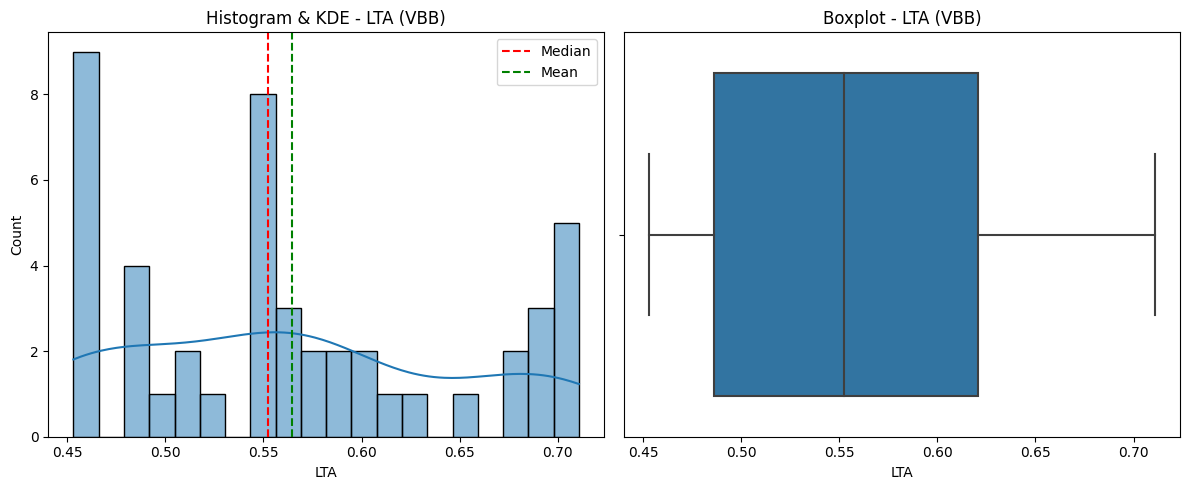

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


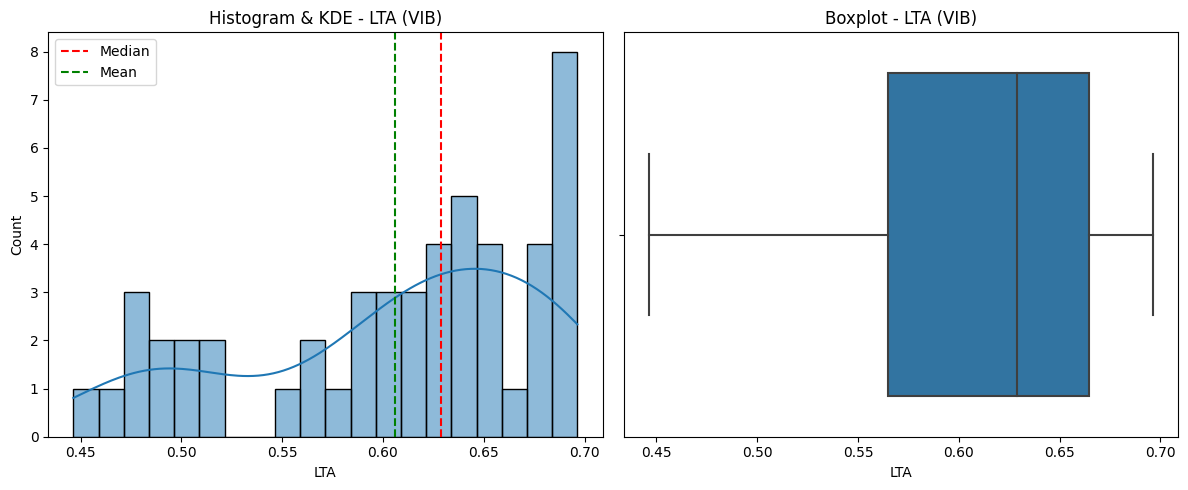


📌 Kiểm tra biến: ROA - Các ngân hàng cần kiểm tra: ['ABB' 'BID' 'KLB' 'MSB' 'NAB' 'OCB' 'PGB' 'SGB' 'TCB' 'TPB' 'VIB' 'VPB']



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


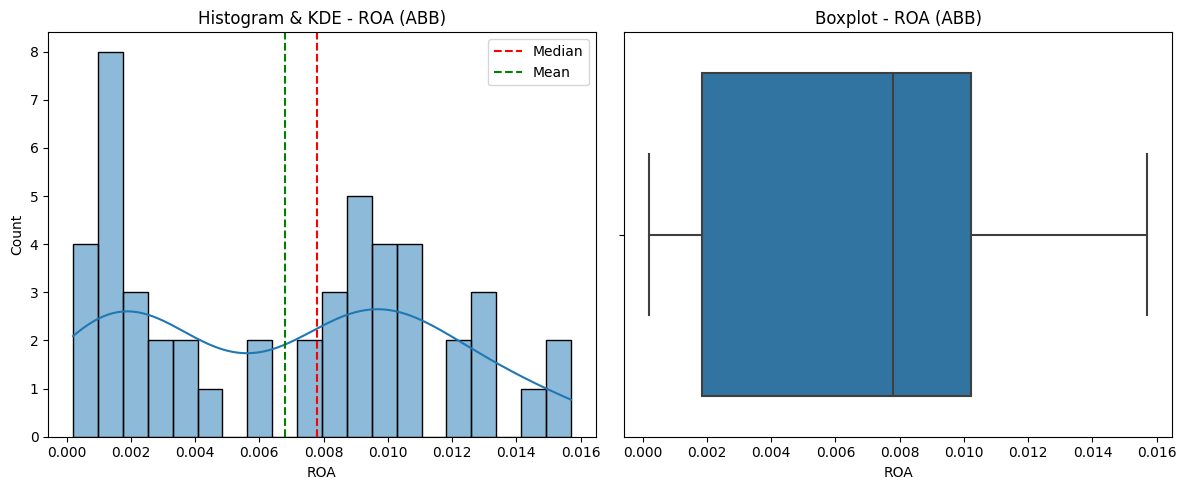

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


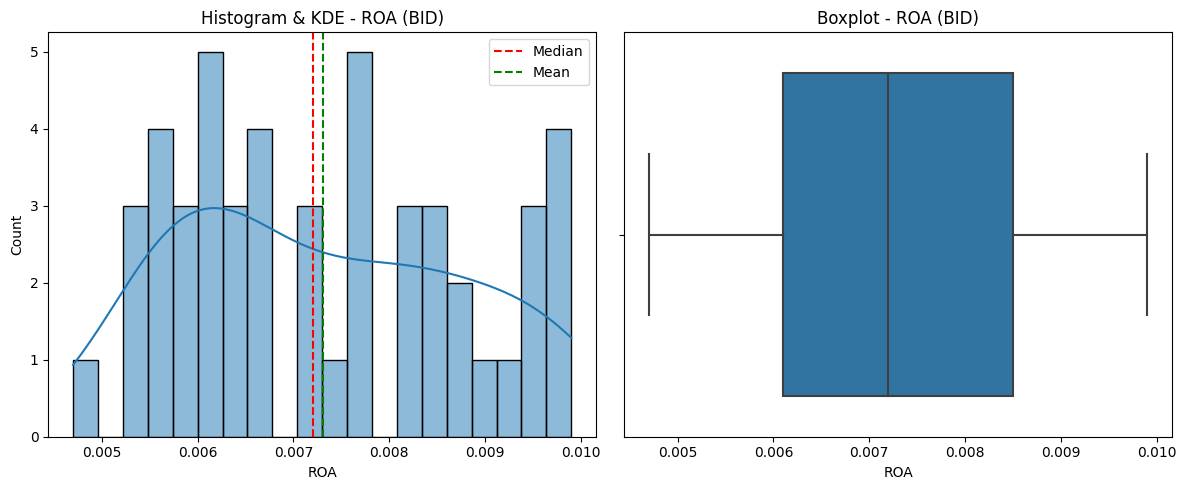

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


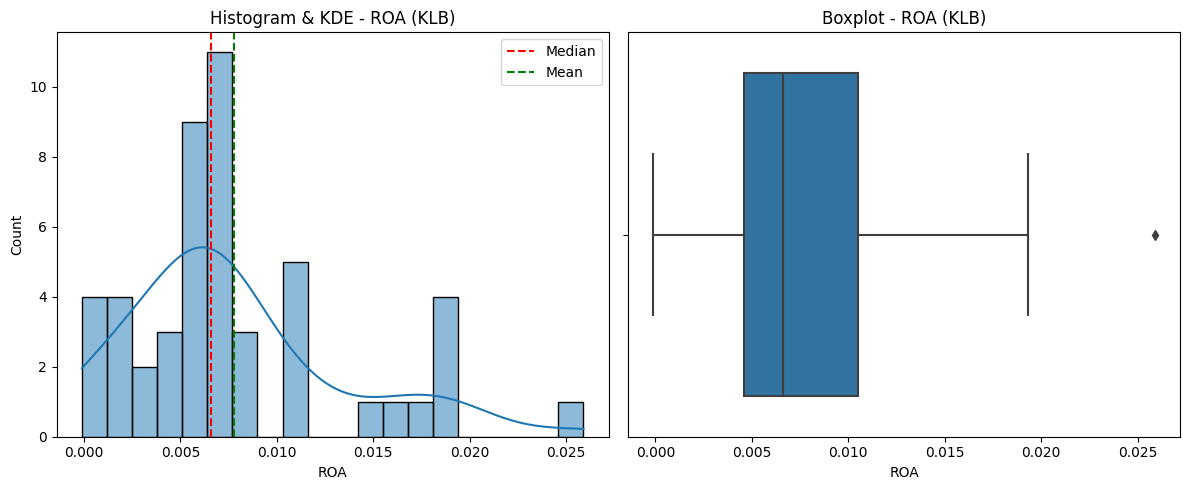

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


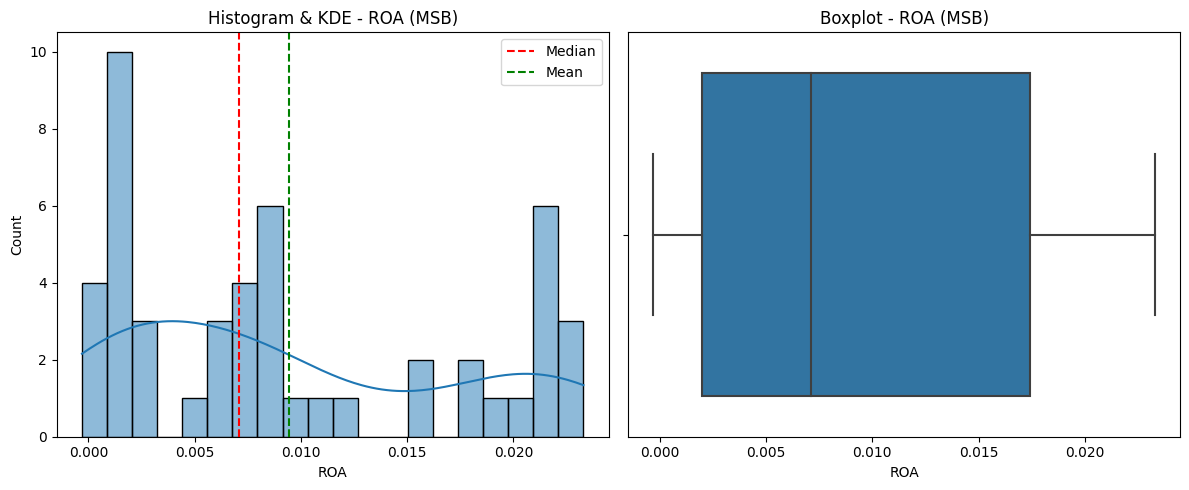

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


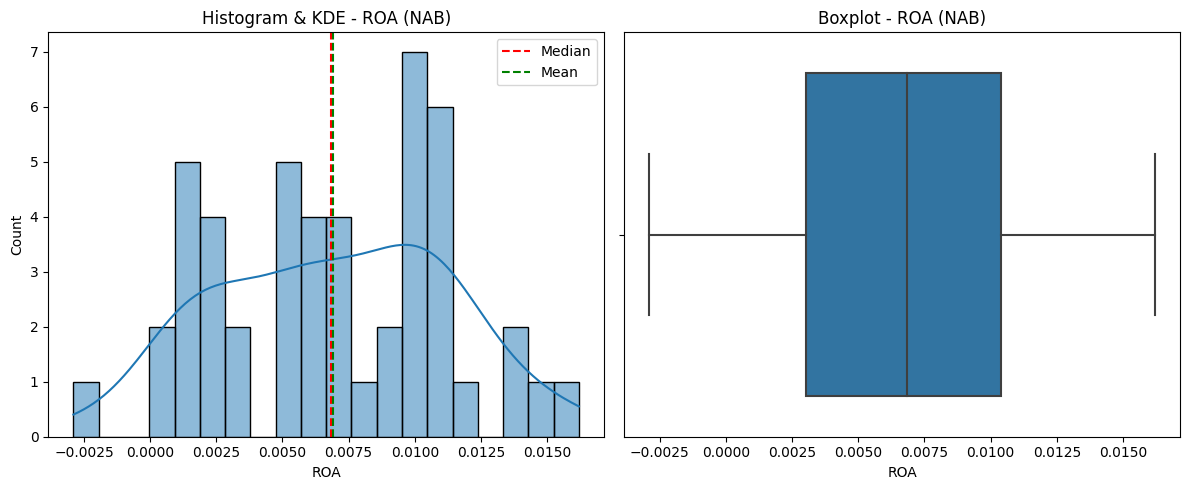

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


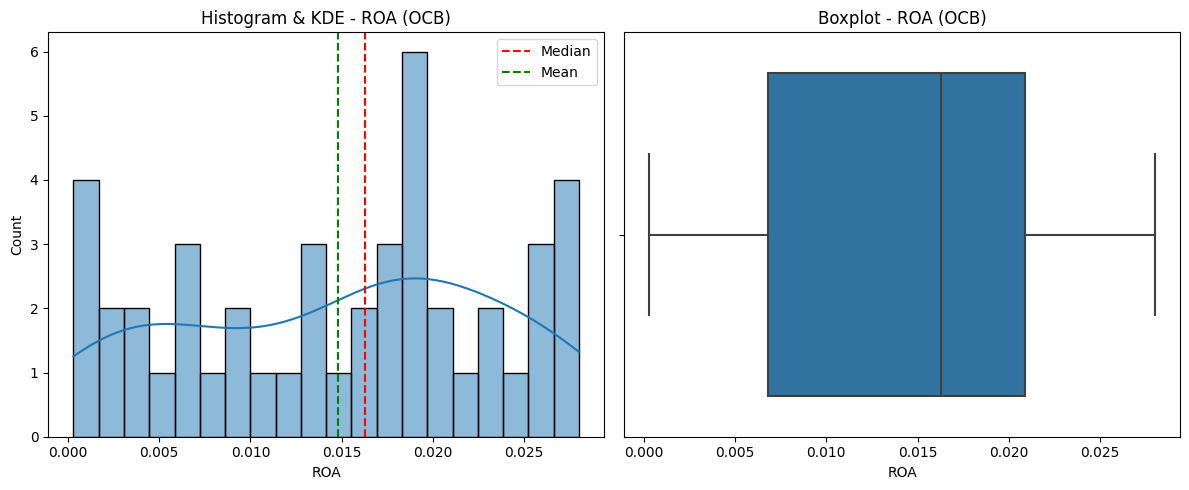

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


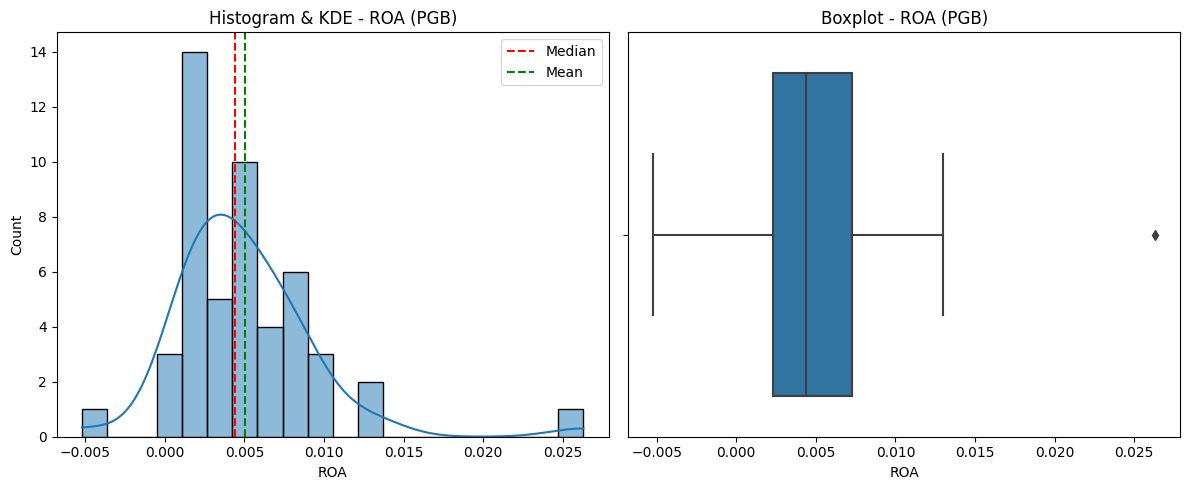

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


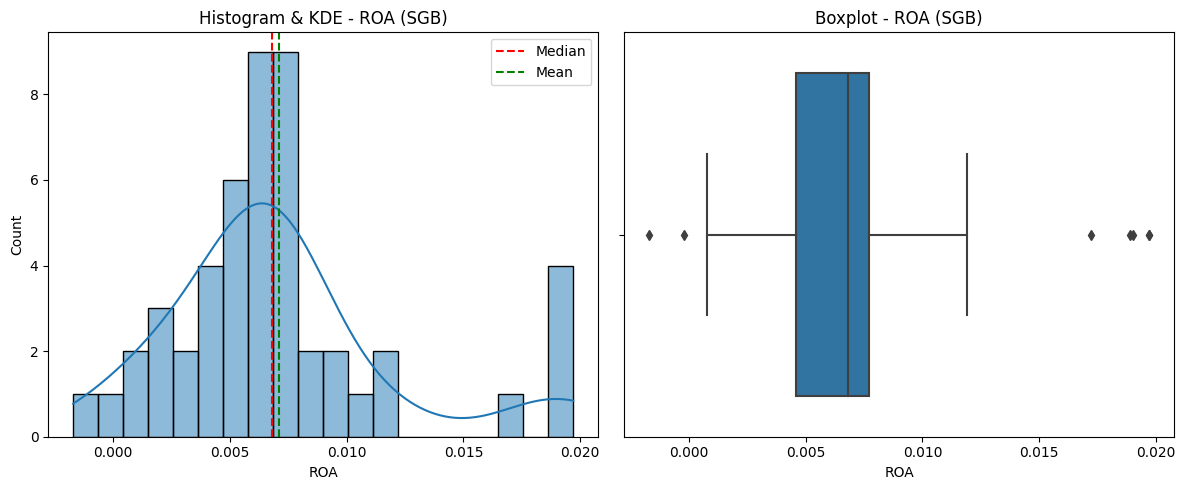

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


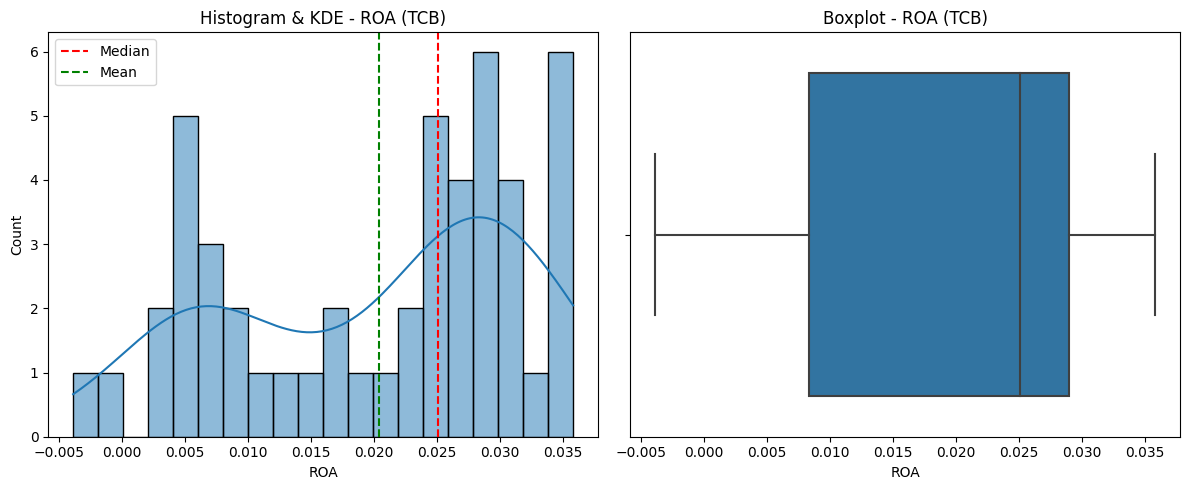

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


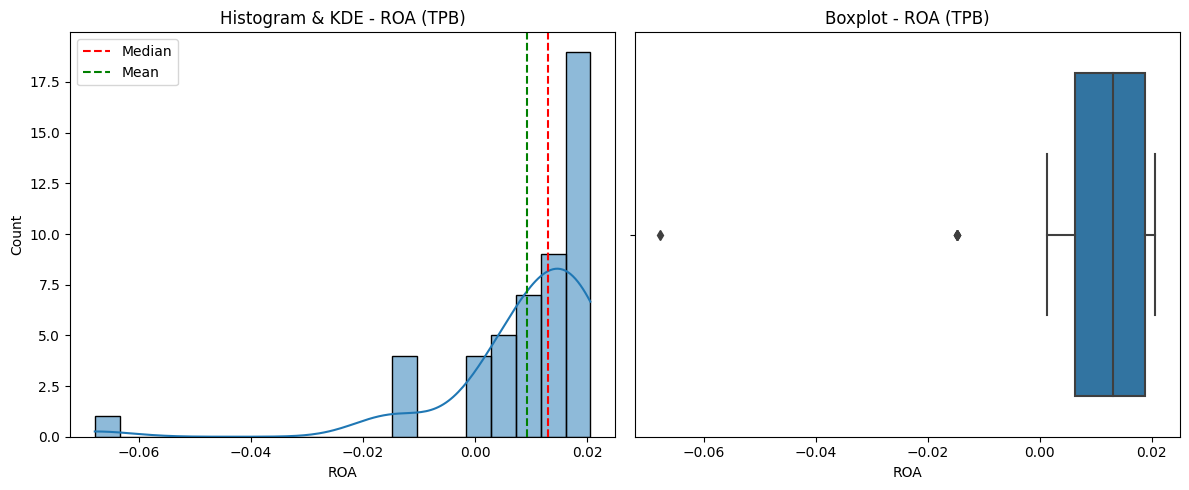

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


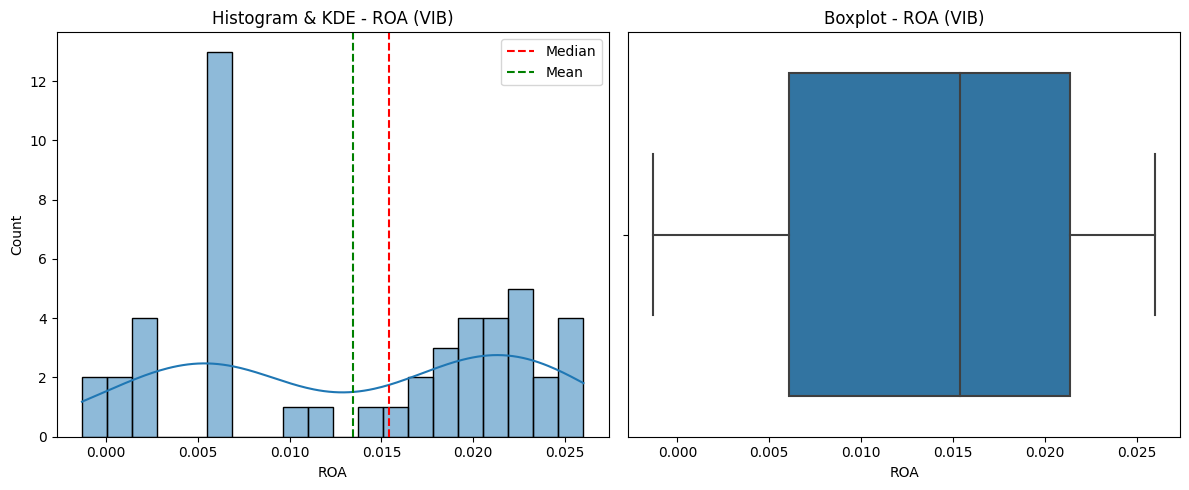

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


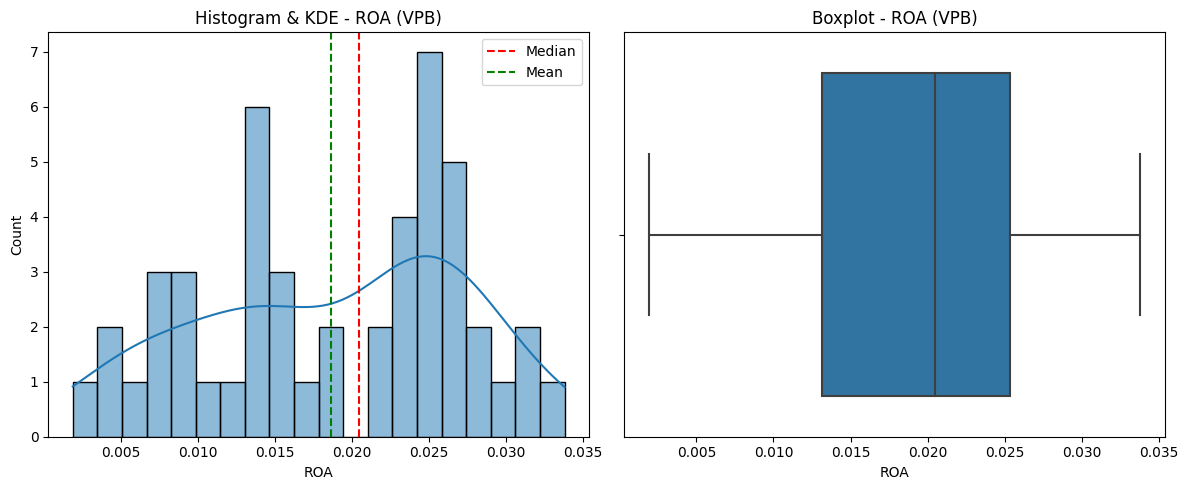


📌 Kiểm tra biến: ROE - Các ngân hàng cần kiểm tra: ['ABB' 'BID' 'KLB' 'MSB' 'NAB' 'OCB' 'PGB' 'SGB' 'TCB' 'TPB' 'VIB' 'VPB']



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


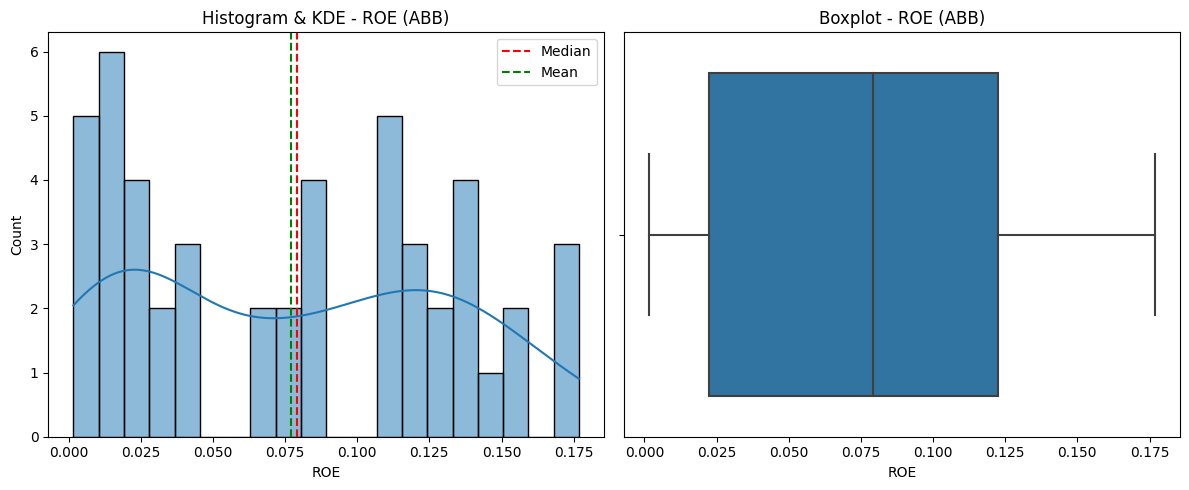

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


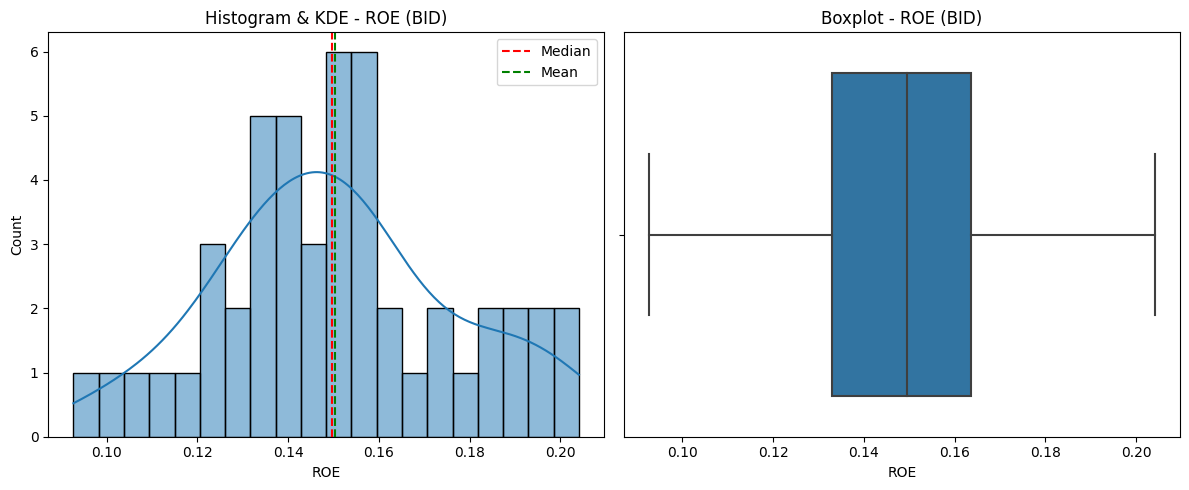

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


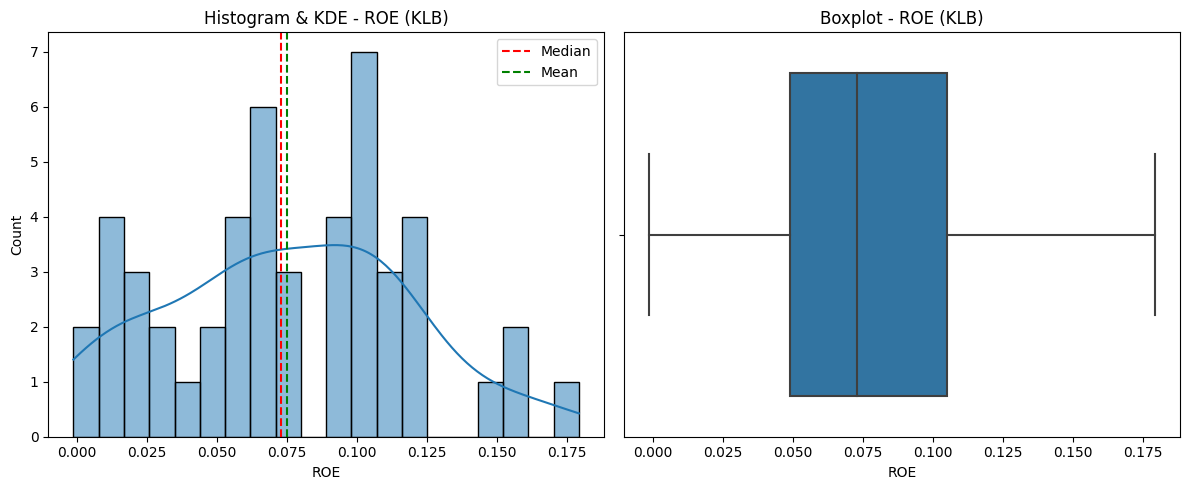

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


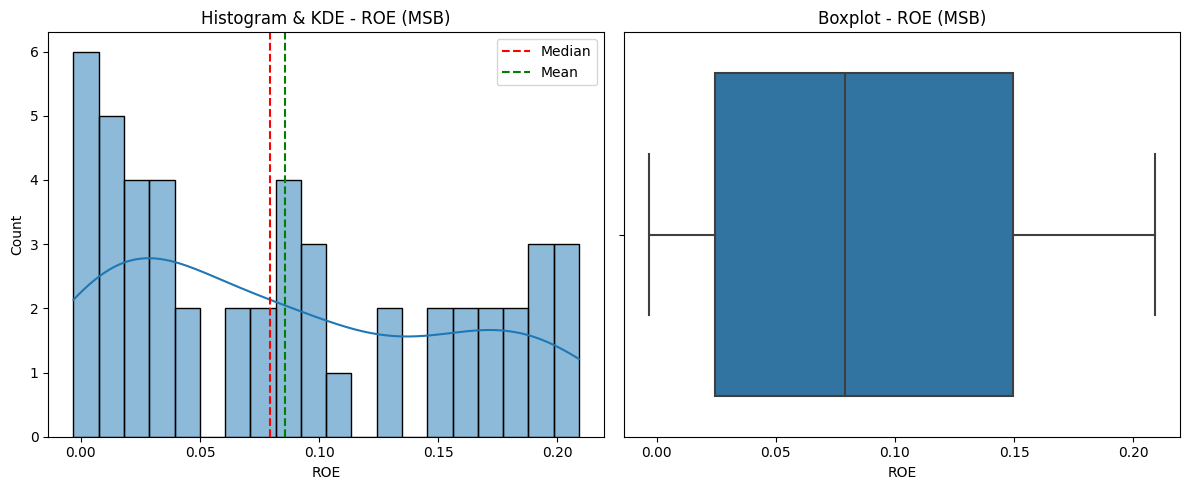

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


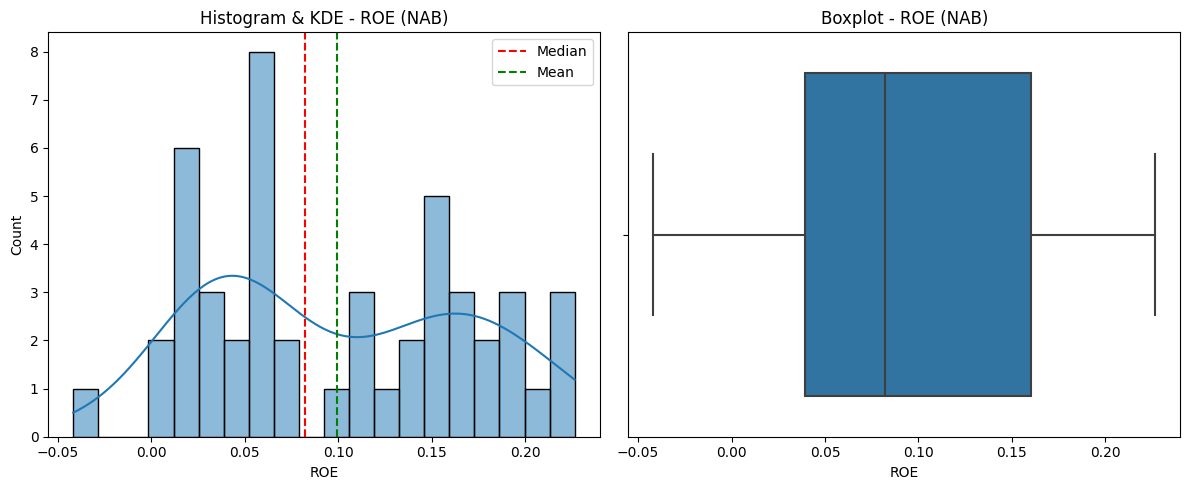

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


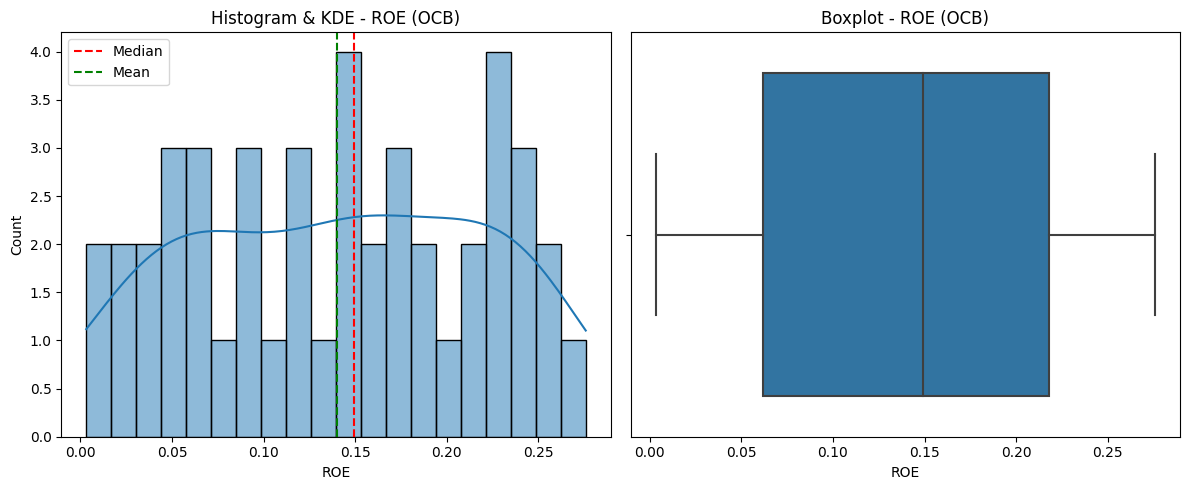

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


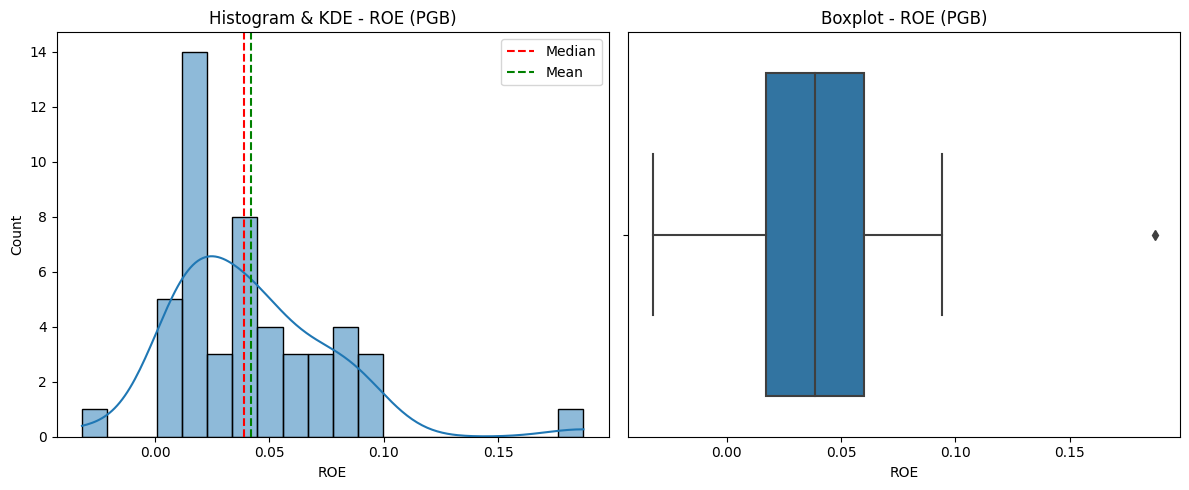

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


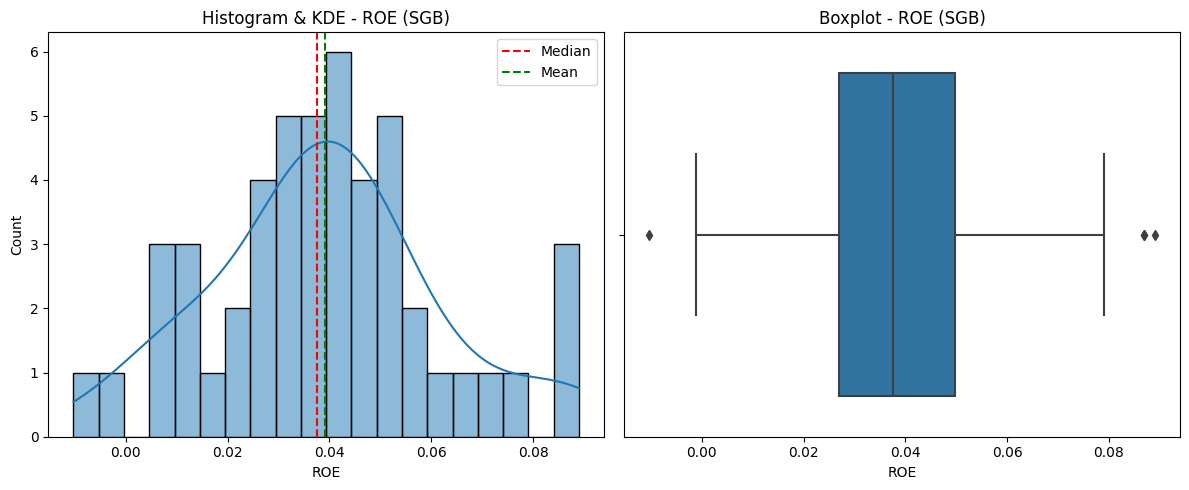

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


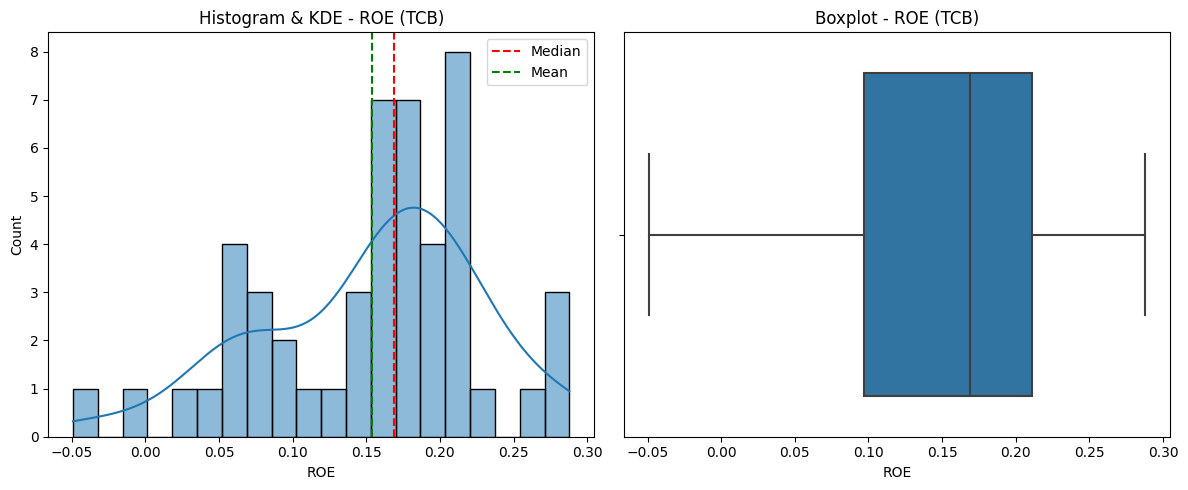

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


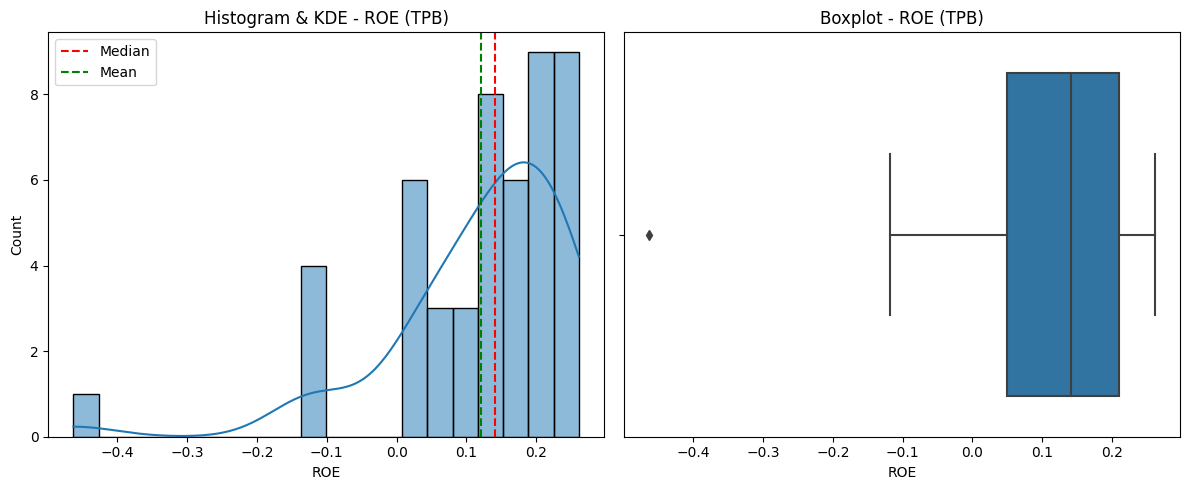

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


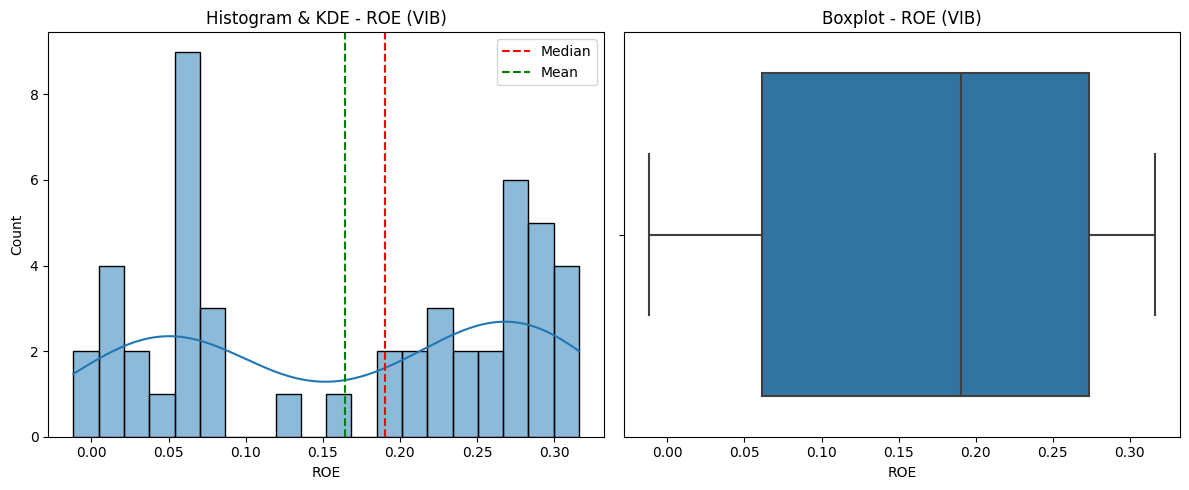

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


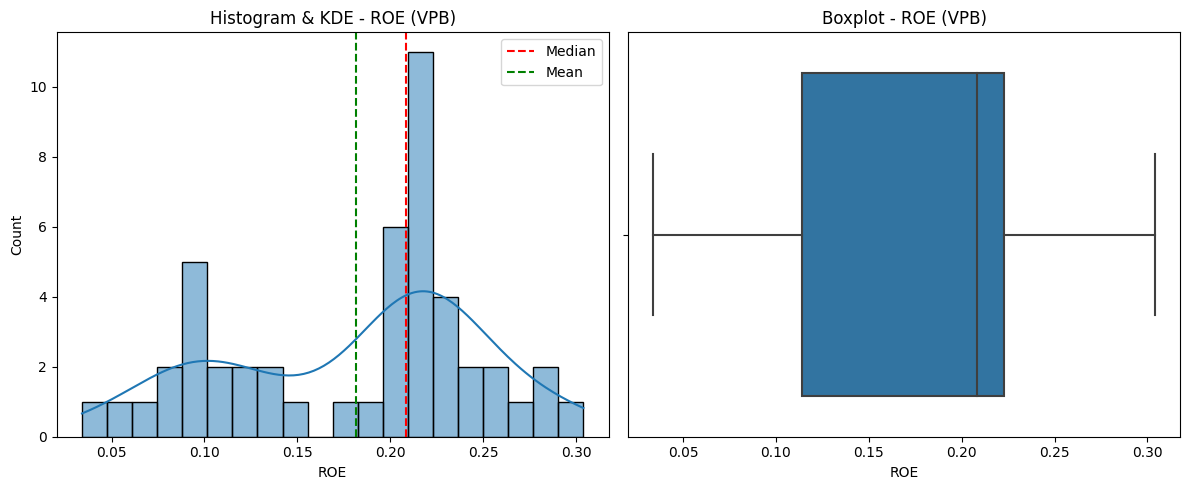


📌 Kiểm tra biến: LDR - Các ngân hàng cần kiểm tra: ['ABB' 'BID' 'KLB' 'MSB' 'OCB' 'PGB' 'SGB' 'SSB' 'TCB' 'TPB' 'VBB' 'VIB']



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


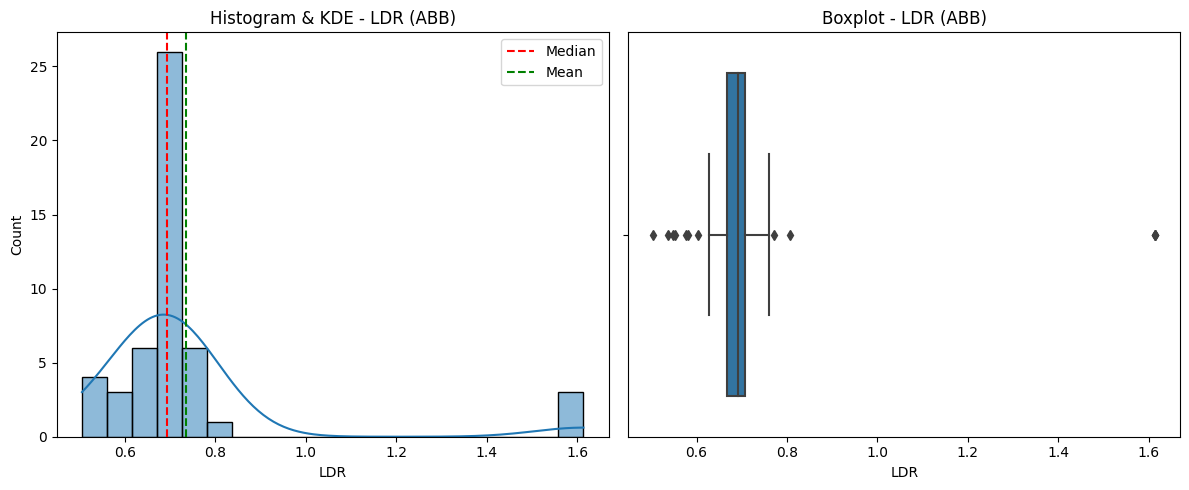

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


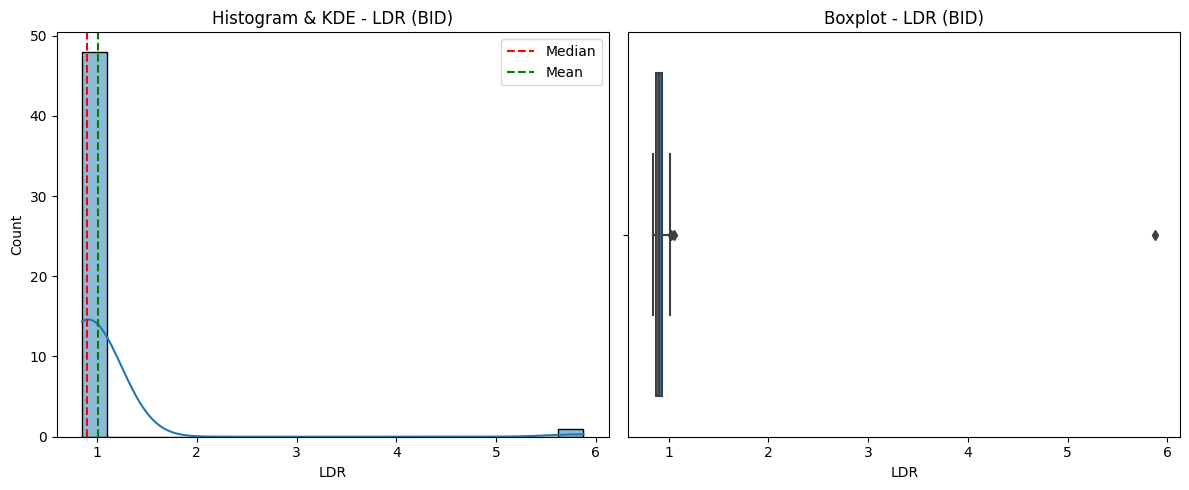

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


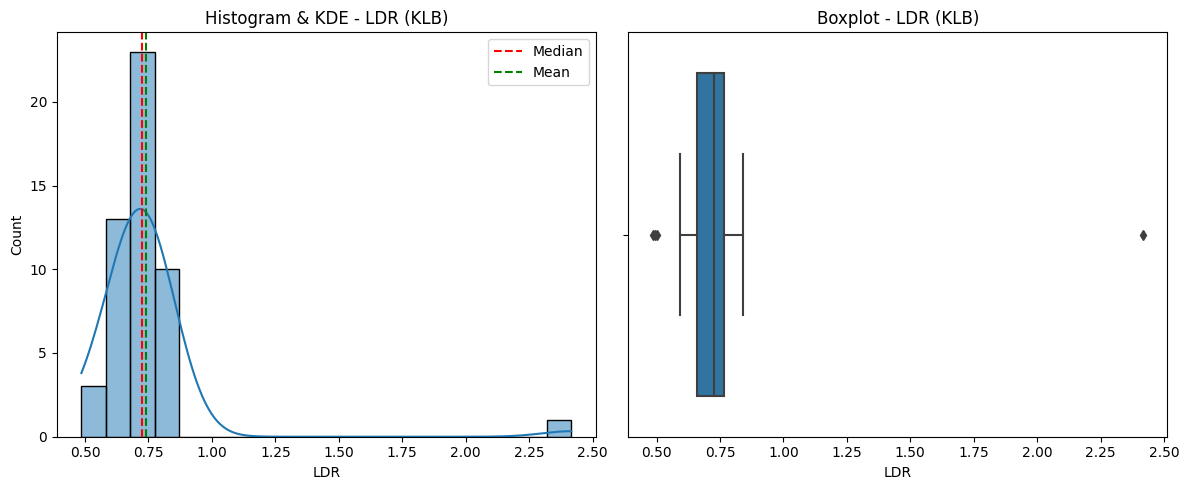

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


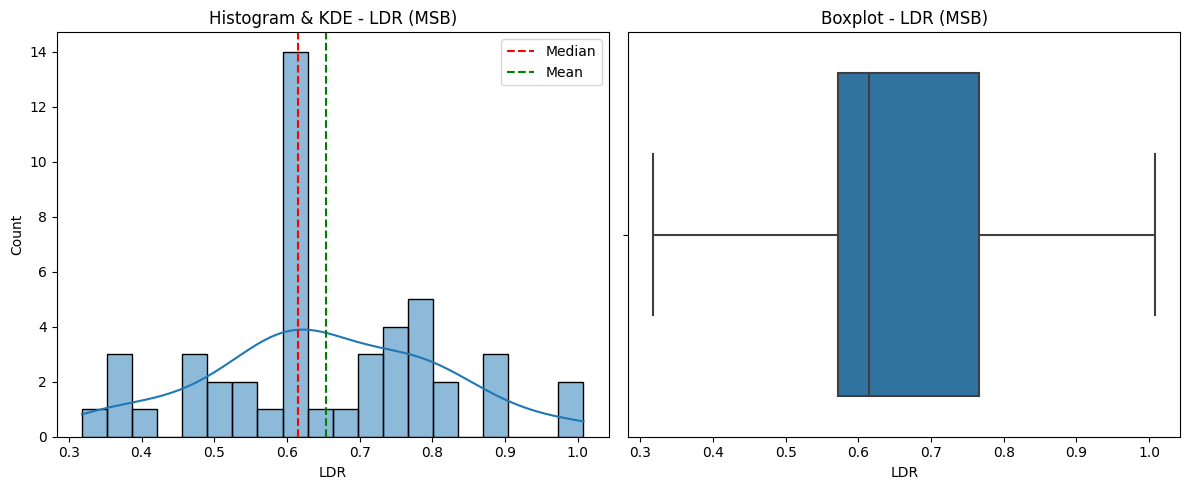

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


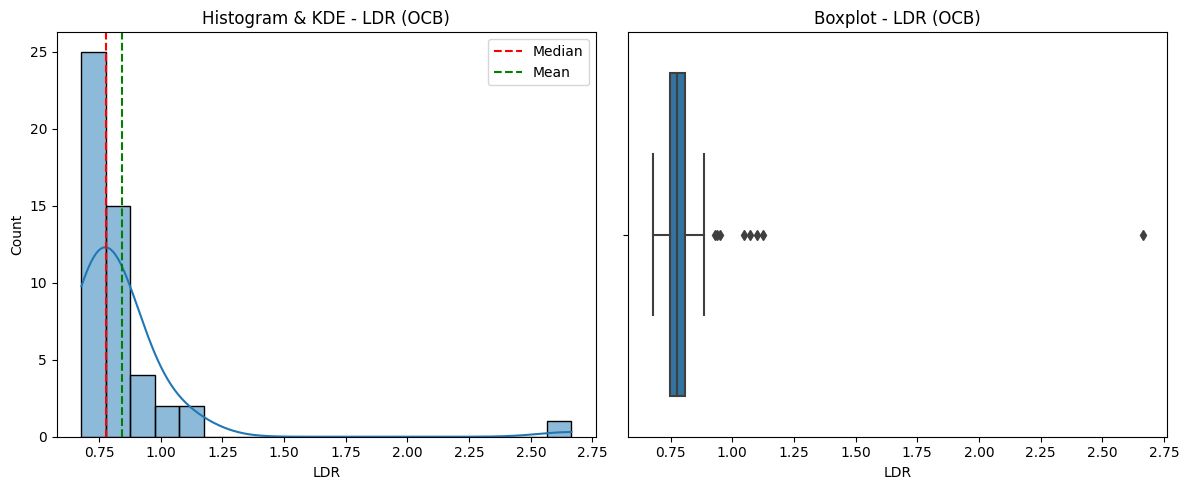

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


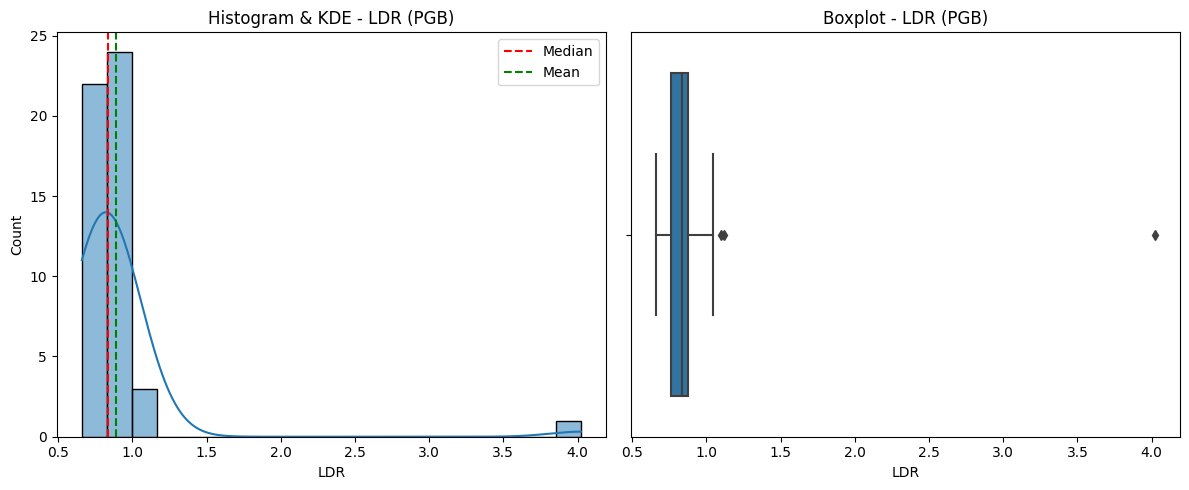

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


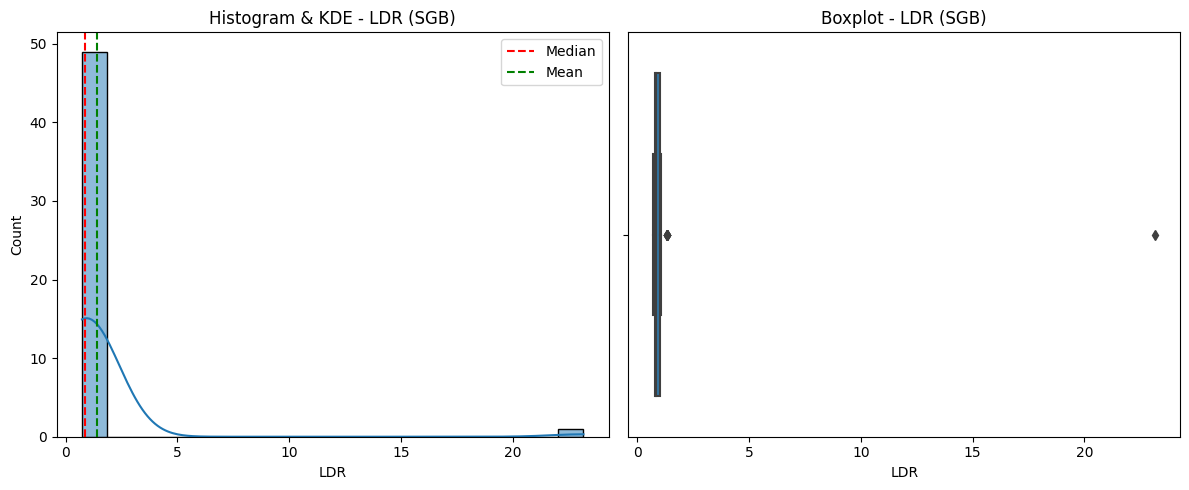

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


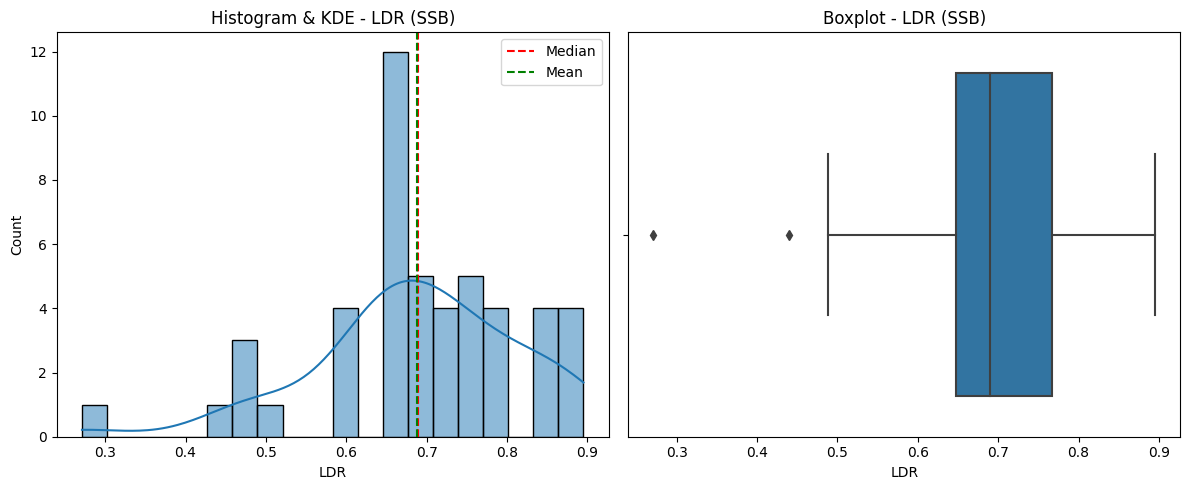

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


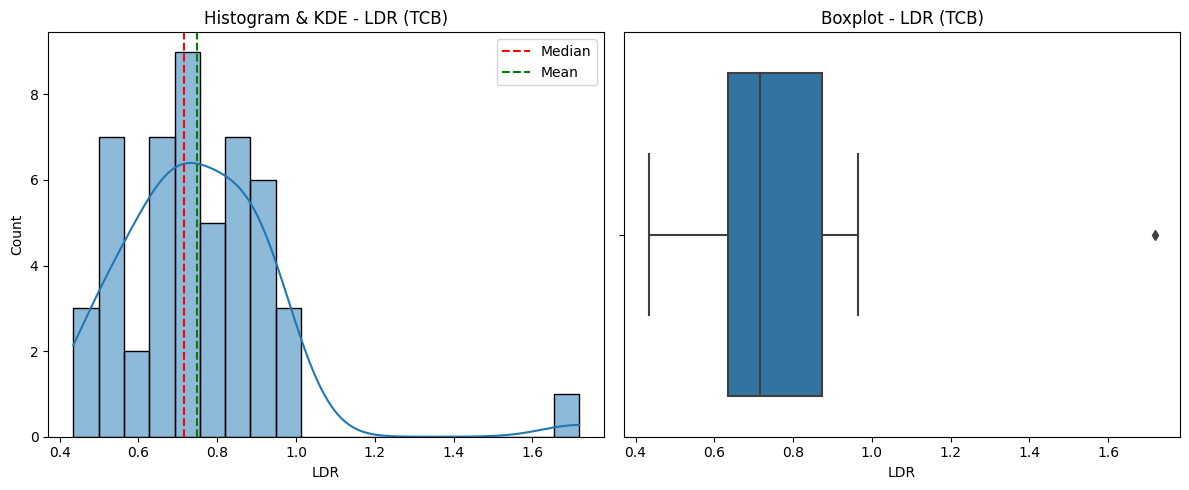

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


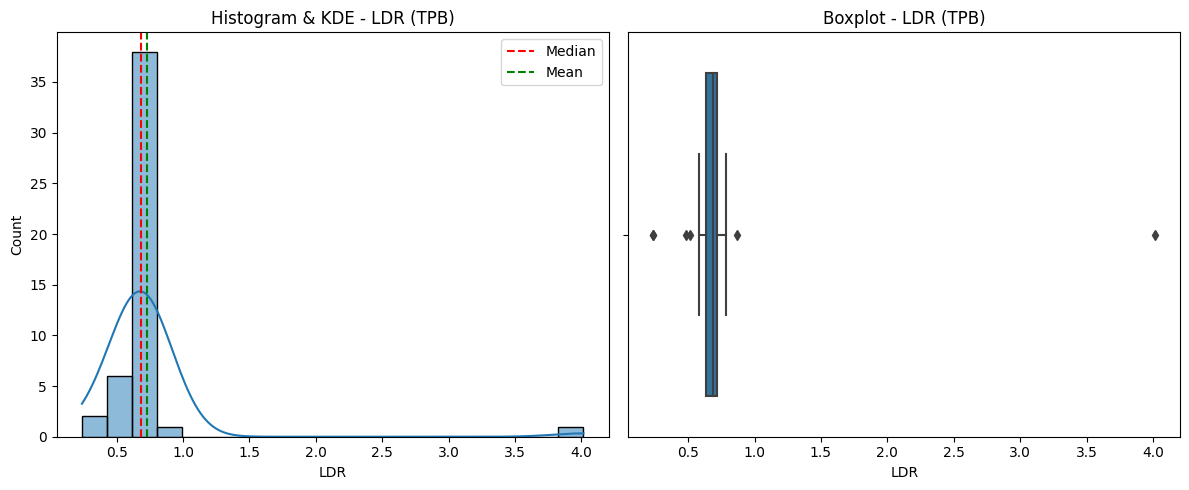

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


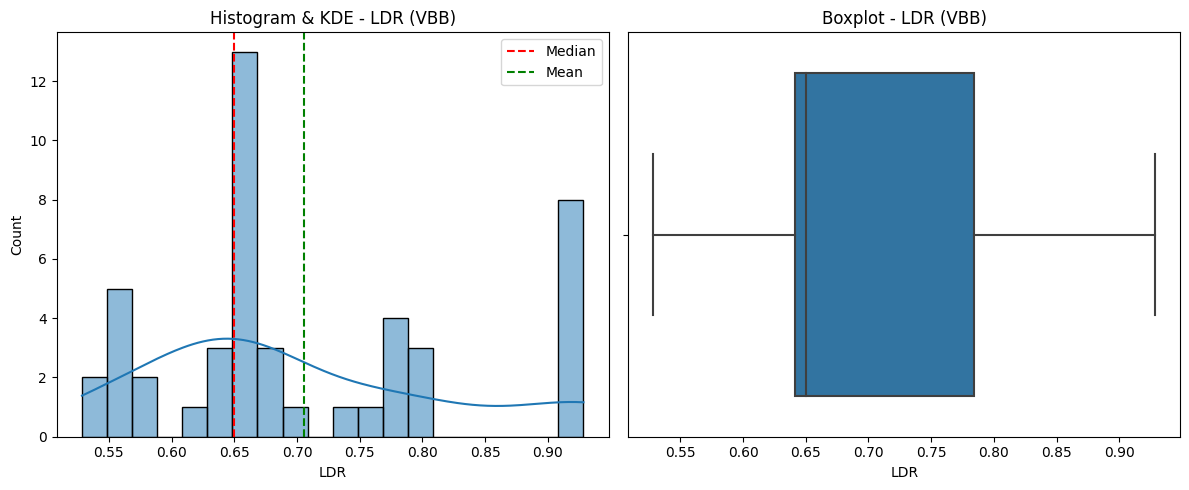

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


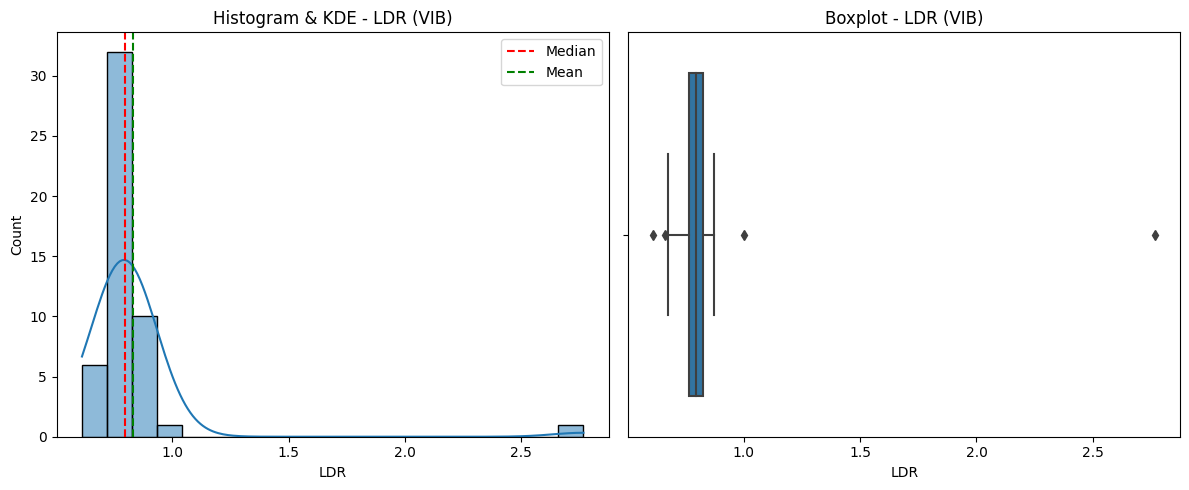

In [21]:
# Tạo thư mục lưu ảnh nếu chưa có
output_dir = "distribution_plots"
os.makedirs(output_dir, exist_ok=True)

# Duyệt qua từng biến
for col in cols_to_check:
    banks_with_issues = micro[micro[col].isna() | (micro[col] == 0)]['bank'].unique()
    
    print(f"\n📌 Kiểm tra biến: {col} - Các ngân hàng cần kiểm tra: {banks_with_issues}\n")
    
    # Duyệt qua từng ngân hàng
    for bank in banks_with_issues:
        bank_data = micro[micro['bank'] == bank][col]  # Dữ liệu của ngân hàng đó

        # Lọc bỏ NaN và 0
        valid_data = bank_data.dropna()
        valid_data = valid_data[valid_data != 0]

        if valid_data.empty:
            print(f"Ngân hàng {bank} không có đủ dữ liệu hợp lệ để vẽ.")
            continue

        # Vẽ biểu đồ phân phối
        plt.figure(figsize=(12, 5))
        
        # Histogram + KDE
        plt.subplot(1, 2, 1)
        if valid_data.nunique() > 1:
            sns.histplot(valid_data, kde=True, bins=20)
        else:
            sns.histplot(valid_data, kde=False, bins=10)
        
        plt.axvline(valid_data.median(), color='r', linestyle='dashed', label="Median")
        plt.axvline(valid_data.mean(), color='g', linestyle='dashed', label="Mean")
        plt.title(f"Histogram & KDE - {col} ({bank})")
        plt.legend()

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=valid_data)
        plt.title(f"Boxplot - {col} ({bank})")

        plt.tight_layout()
        plt.show()

        # Lưu ảnh vào thư mục
        save_path = os.path.join(output_dir, f"{col}_{bank}.png")
        plt.savefig(save_path)
        plt.close()  # Đóng figure để tránh tràn bộ nhớ

In [22]:
from PIL import Image

# Thư mục chứa ảnh đã lưu
image_dir = "distribution_plots"
output_pdf = "merged_distribution_plots.pdf"

# Lấy danh sách tất cả ảnh PNG trong thư mục
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

# Sắp xếp file theo thứ tự (tránh lộn xộn)
image_files.sort()

# Kiểm tra nếu có ảnh để gộp
if not image_files:
    print("Không tìm thấy ảnh trong thư mục!")
else:
    # Mở ảnh đầu tiên để tạo file PDF
    first_image = Image.open(image_files[0]).convert("RGB")
    
    # Mở các ảnh còn lại và chuyển sang RGB
    image_list = [Image.open(img).convert("RGB") for img in image_files[1:]]

    # Lưu thành PDF
    first_image.save(output_pdf, save_all=True, append_images=image_list)

In [23]:
# Hàm điền giá trị NaN bằng trung vị và giá trị 0 bằng mean
def fill_missing_values(df, col_name, special_case_banks=None):
    if special_case_banks is None:
        special_case_banks = []
    
    for bank in df['bank'].unique():
        bank_data = df[df['bank'] == bank]
        median_value = bank_data[col_name].median()
        mean_value = bank_data[col_name].mean()
        
        if bank in special_case_banks:
            df.loc[df['bank'] == bank, col_name] = mean_value
        else:
            df.loc[(df['bank'] == bank) & (df[col_name].isna()), col_name] = median_value
            df.loc[(df['bank'] == bank) & (df[col_name] == 0), col_name] = mean_value
    
    return df

if 'micro' in globals():
    variables = ["PCR", "LTA", "ROA", "ROE", "LDR"]
    special_case_banks = ["BID", "SGB"]
    for var in variables:
        special_case = special_case_banks if var == "ROE" else None
        micro = fill_missing_values(micro, var, special_case)


In [24]:
micro.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,bank,quarterly,year,time,NPL,IR,GDP,IIP,INF,CPI,UN,M2,PCR,LTA,ROA,ROE,LDR
0,ABB,1,2012,2012q1,0.0325,0.138700,0.0464,0.0650,NaN,0.1415,0.0222,NaN,0.0160,0.499451,0.00740,0.065500,0.705935
1,ABB,2,2012,2012q2,0.0325,0.113667,0.0480,0.0802,NaN,0.0690,0.0218,NaN,0.0153,0.399700,0.00639,0.072606,0.547300
2,ABB,3,2012,2012q3,0.0325,0.092067,0.0505,0.0965,NaN,0.0648,0.0229,NaN,0.0160,0.499451,0.00740,0.065500,0.705935
3,ABB,4,2012,2012q4,0.0290,0.093667,0.0544,0.0593,NaN,0.0681,0.0212,NaN,0.0221,0.398600,0.00910,0.083000,0.504700
4,ABB,1,2013,2013q1,0.0325,0.090000,0.0476,0.0516,NaN,0.0664,0.0227,NaN,0.0221,0.407600,0.00880,0.083000,1.614000


In [25]:
zero_counts = (micro == 0).sum()
nan_counts = micro.isna().sum()

checking = pd.DataFrame({
    "Cột": micro.columns,
    "Số giá trị NaN": nan_counts.values,
    "Số giá trị 0": zero_counts.values
})

checking

,Cột,Số giá trị NaN,Số giá trị 0
0,bank,0,0
1,quarterly,0,0
2,year,0,0
3,time,0,0
4,NPL,0,0
5,IR,0,0
6,GDP,0,0
7,IIP,0,0
8,INF,299,0
9,CPI,0,23


In [26]:
micro.to_csv("/kaggle/working/filled_micros.csv", index=False)